In [61]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [461]:
from helper_functions import stock_list, stock_prices

In [63]:
import time
import pandas as pd
import numpy as np

tic = time.time()

testsmpl=126
interval = 252*3

interval = 521

In [88]:
tickers = stock_list.get_stock_list(index='DOW JONES')
tickers = ['AES', 'MMM']
symbolsnum = len(tickers)

In [89]:
data_historical = stock_prices.get_prices(tickers)

[*********************100%***********************]  2 of 2 completed


In [272]:
data = data_historical[-interval:]
# data = data_historical[-interval:]

In [273]:
data = np.log(data)

data_train = data[:-testsmpl]
data_test = data[-testsmpl-1:-1]

In [274]:
data_train = data_train[:-1]

In [275]:
toc = time.time()
print(f'Symbols Fetched... elapsed time: {toc - tic}')

Symbols Fetched... elapsed time: 7484.758439064026


In [276]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [277]:
def get_best_k_ar(df, maxLags=5):
    model = VAR(df)
    results = model.fit(maxlags=maxLags, ic='aic')
    return results.k_ar

In [278]:
def get_is_cointegrated(df, alpha=0.05, lags=0, verbose=True): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,0,lags)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    print(out.evec)
    print(out.eig)
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    if verbose:
        print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
        for col, trace, cvt in zip(['r=0', 'r<=1'], traces, cvts):
            print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        
    return traces[0]>cvts[0]

In [279]:
Lopt = get_best_k_ar(data_train)
Lopt = max(1, Lopt-1)
get_is_cointegrated(data_train[['MMM', 'AES']], alpha=0.05, lags=Lopt, verbose=True)

[[16.39032449 -3.07821141]
 [-5.5490806  10.634152  ]]
[5.35761106e-02 6.69824767e-05]
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
r=0    ::  21.5      > 15.4943   =>   True
r<=1   ::  0.03      > 3.8415    =>   False


True

In [280]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order

In [281]:
lag_order = select_order(data_train, maxlags=10, deterministic="ci")
lag_order = lag_order.aic

In [282]:
rank_test = select_coint_rank(data_train, 0, lag_order, method="trace",
                              signif=0.05)

In [283]:
def get_cointegration_params(df, verbose=False):
    lag_order = select_order(df, maxlags=10, deterministic="ci")
    lag_order = lag_order.aic

    rank_test = select_coint_rank(df, 0, lag_order, method="trace",
                              signif=0.05)

    is_cointegrated = rank_test.test_stats[0] > rank_test.crit_vals[0]
    if verbose:
        print(rank_test.summary())
    if not is_cointegrated:
        return False, np.NaN, np.NAN
    
    model = VECM(df, deterministic="ci",
             k_ar_diff=lag_order,
             coint_rank=rank_test.rank)
    vecm_res = model.fit()

    return True, vecm_res.beta, vecm_res.const_coint

In [284]:
is_cointegrated, BJ2n, C0J2n =  get_cointegration_params(data_train)

In [285]:
BJ2n = np.array([[1], [-2.9537]])
C0J2n = 4.2197

In [286]:
cointRinsmpl = np.matmul(data_train, BJ2n) + C0J2n
cointRtest = np.matmul(data_test, BJ2n) + C0J2n

In [293]:
scointR = np.std(cointRinsmpl)[0]
mcointR = np.mean(cointRinsmpl)[0]

In [303]:
cointR = cointRinsmpl.append(cointRtest)
longs = cointR<=mcointR-2*scointR
shorts=cointR>=mcointR+2*scointR; 
exitLongs=cointR>=mcointR-1*scointR; 
exitShorts=cointR<=mcointR+1*scointR; 

In [378]:
positionsL = np.zeros((cointR.shape[0], 2))
positionsS = np.zeros((cointR.shape[0], 2))

positionsL = pd.DataFrame(positionsL)
positionsS = pd.DataFrame(positionsS)

In [399]:
positionsL.iloc[positionsL[longs.values].index, 0] = 1
positionsL.iloc[positionsL[longs.values].index, 1] = -1
positionsL.iloc[positionsL[exitLongs.values].index, 0] = 0
positionsL.iloc[positionsL[exitLongs.values].index, 1] = 0

positionsS.iloc[positionsS[shorts.values].index, 0] = -1
positionsS.iloc[positionsS[shorts.values].index, 1] = 1
positionsS.iloc[positionsS[exitShorts.values].index, 0] = 0
positionsS.iloc[positionsS[exitShorts.values].index, 1] = 0

In [400]:
positions = positionsL + positionsS

In [423]:
yret = np.log(data_train.append(data_test)).diff()
yret = yret[1:]

In [442]:
pnl=(
    positions[0:-1][0] * yret[yret.columns[0]].values 
    - BJ2n[1][0]*positions[0:-1][1]*yret[yret.columns[1]].values
)

In [ ]:
rsuminsmpl = np.cumsum(pnl(1:end-testsmpl,1));

In [450]:
rsuminsmpl = np.cumsum(pnl[:-data_test.shape[0]])
rsumtest = np.cumsum(pnl[-data_test.shape[0]:])

In [459]:
ShrpRatinsmpl = np.sqrt(252)*np.mean(pnl[:-data_test.shape[0]])/np.std(pnl[:-data_test.shape[0]])
ShrpRatiTest = np.sqrt(252)*np.mean(pnl[-data_test.shape[0]:])/np.std(pnl[-data_test.shape[0]:])

In [462]:
import matplotlib.pyplot as plt

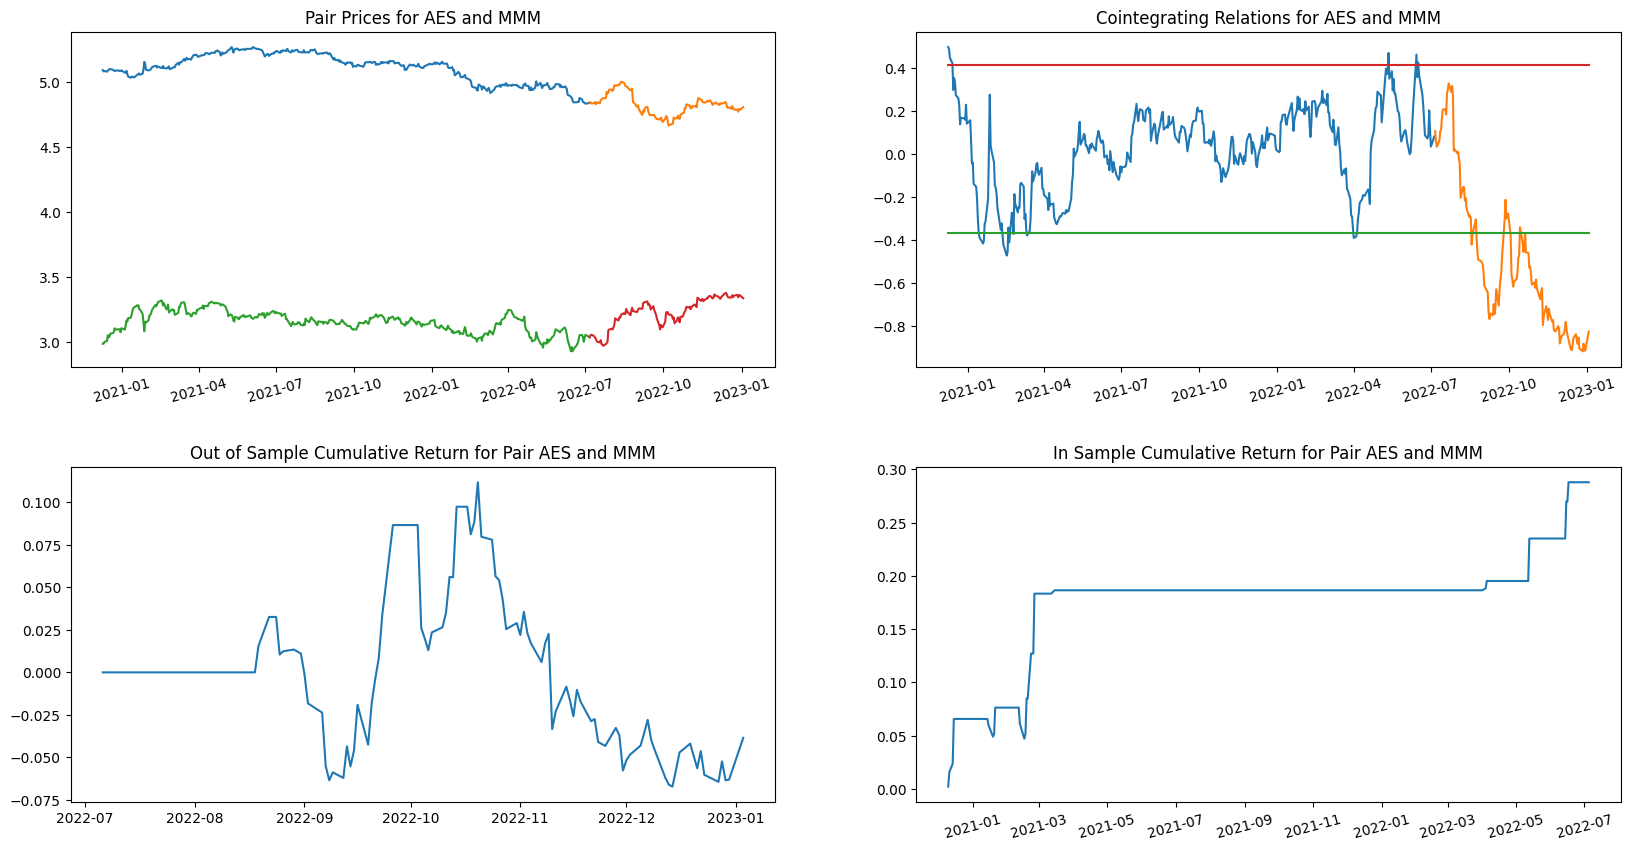

In [505]:
ticker1, ticker2 = data_train.columns
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(data_train[ticker1])
axs[0, 0].plot(data_test[ticker1])
axs[0, 0].plot(data_train[ticker2])
axs[0, 0].plot(data_test[ticker2])
axs[0, 0].set_title(f'Pair Prices for {ticker1} and {ticker2}')
axs[0, 0].tick_params(axis='x', rotation=15)

axs[0, 1].plot(cointR[:data_train.shape[0]])
axs[0, 1].plot(cointR[-data_test.shape[0]:])
axs[0, 1].set_title(f'Cointegrating Relations for {ticker1} and {ticker2}')
axs[0, 1].plot(cointR.index, [mcointR - 2*scointR]*cointR.shape[0])
axs[0, 1].plot(cointR.index, [mcointR + 2*scointR]*cointR.shape[0])
axs[0, 1].tick_params(axis='x', rotation=15)

axs[1, 0].plot(data_test.index, rsumtest)
axs[1, 0].set_title(f'Out of Sample Cumulative Return for Pair {ticker1} and {ticker2}')

axs[1, 1].plot(data_train.index[1:], rsuminsmpl)
axs[1, 1].set_title(f'In Sample Cumulative Return for Pair {ticker1} and {ticker2}');
axs[1, 1].tick_params(axis='x', rotation=15);

fig.subplots_adjust(hspace=.3)